### Load Data

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sample_data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA and Feature Selection
Are there any missing values?

In [ ]:
df[df.columns].isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Great! Lets get general idea of the features in the data.  

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.shape

(284807, 31)

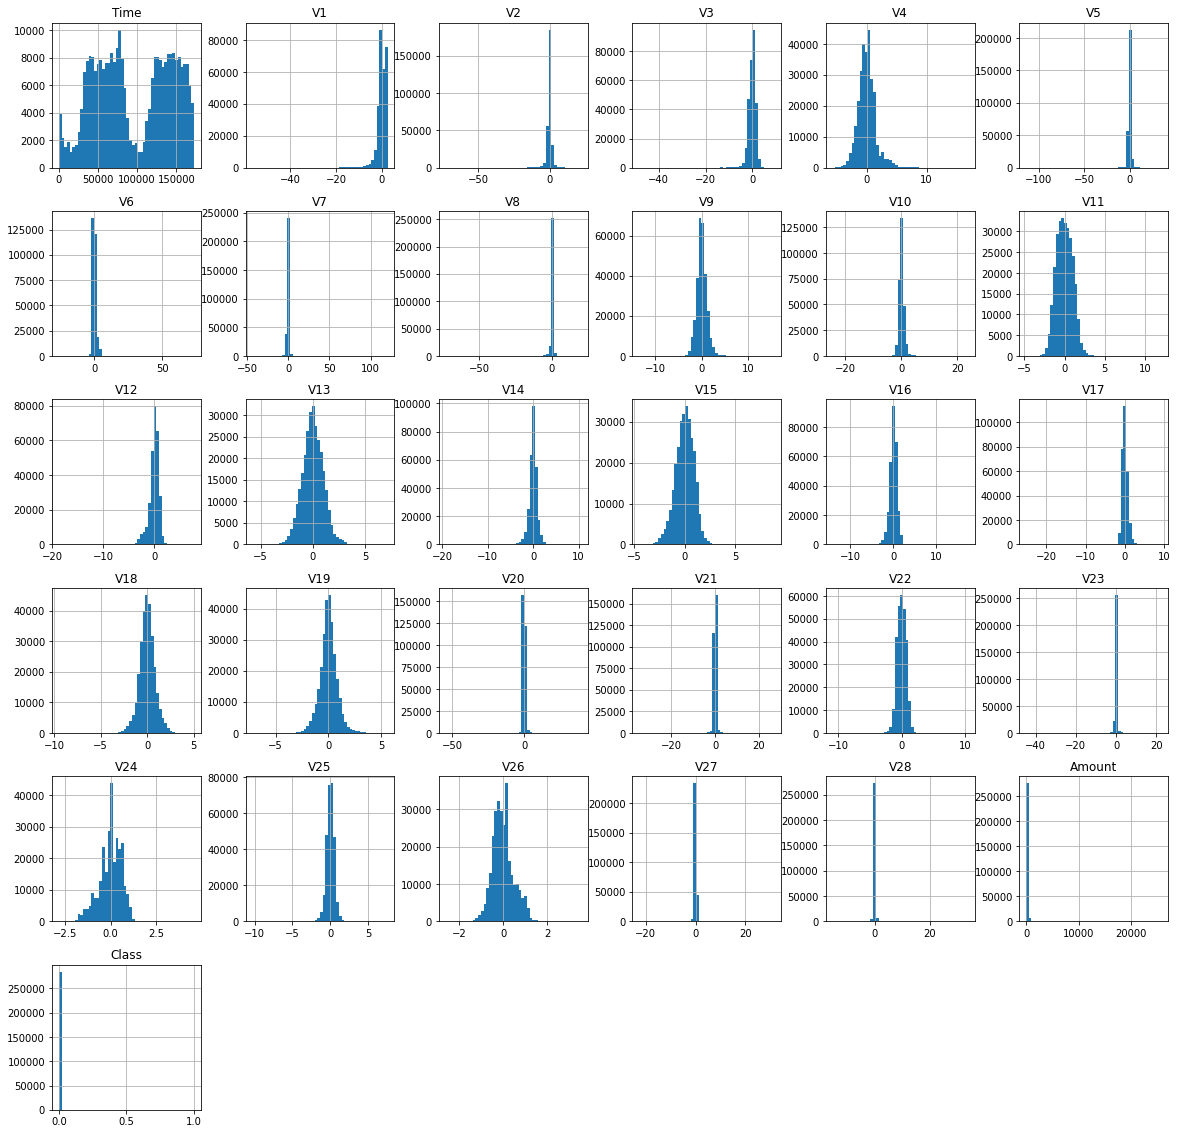

In [ ]:
df.hist(bins = 50, figsize = (20,20))
plt.show()

Time!

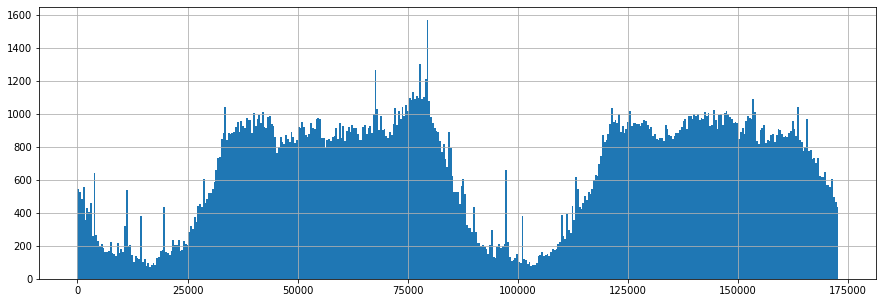

In [ ]:
df['Time'].hist(bins = 425, figsize = (15,5))
plt.show()

Clearly, it looks like there are cycles.  We take a complete cycle.    

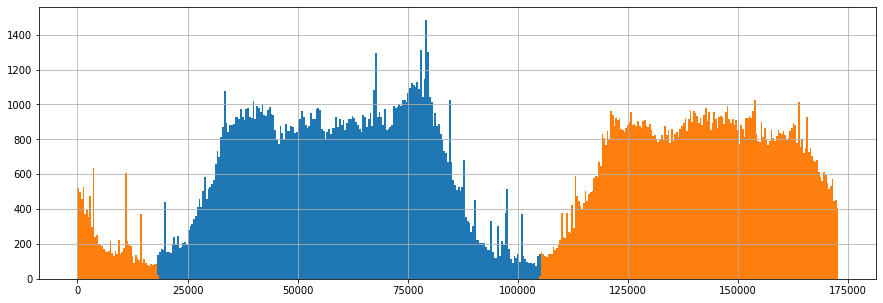

In [ ]:
Data = df.loc[(df['Time']>18103) & (df['Time']<105172),:]
Data_test = df.loc[(df['Time']<18104) | (df['Time']>105171),:] 

Data['Time'].hist(bins = 213, figsize = (15,5))
Data_test['Time'].hist(bins = 450, figsize = (15,5))
plt.show()

In [ ]:
Data = Data.reset_index()
Data = Data.drop('index', axis =1)

Data_test = Data_test.reset_index()
Data_test = Data_test.drop('index', axis = 1)

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
normal = Data.loc[Data['Class'] == 0, :]
normal.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.000000,144330.0
mean,59320.390335,-0.214120,0.018896,0.591197,0.116878,-0.234740,0.068172,-0.090541,0.054483,-0.070149,-0.004772,0.166054,0.044388,-0.011945,0.038898,0.193195,0.000202,0.044509,-0.063259,-0.020831,0.037715,-0.037209,-0.104455,-0.026928,0.009723,0.113726,0.016979,0.000844,0.002733,90.171789,0.0
std,19398.239899,1.810318,1.618638,1.225317,1.327093,1.298687,1.286040,1.115794,1.188649,1.103690,1.021953,1.007065,0.959070,1.001555,0.843452,0.944672,0.836941,0.752786,0.816254,0.807821,0.733228,0.703164,0.646355,0.589844,0.596623,0.452686,0.485732,0.386252,0.314661,250.622833,0.0
min,18105.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-31.764946,-73.216718,-6.290730,-14.741096,-4.049895,-14.745849,-5.791881,-18.392091,-4.097947,-9.860339,-16.511143,-5.114520,-7.213527,-22.838548,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.0
25%,42970.250000,-1.015090,-0.559749,0.068315,-0.729612,-0.886177,-0.677566,-0.602425,-0.141814,-0.711798,-0.491675,-0.568580,-0.365430,-0.667526,-0.346316,-0.380291,-0.471630,-0.418150,-0.536494,-0.503843,-0.178132,-0.225625,-0.550993,-0.169945,-0.328726,-0.164683,-0.325624,-0.061401,-0.010080,5.980000,0.0
50%,59656.000000,-0.229772,0.105579,0.676906,0.143554,-0.283923,-0.188897,-0.048603,0.075854,-0.150218,-0.099489,0.083969,0.172596,-0.015116,0.058415,0.311108,0.070184,-0.032010,-0.072240,-0.024904,-0.032245,-0.055087,-0.080002,-0.040659,0.063373,0.154808,-0.060710,0.011417,0.023127,23.000000,0.0
75%,75349.000000,1.169169,0.790708,1.316130,0.955407,0.297277,0.455878,0.435108,0.371306,0.497744,0.436740,0.991245,0.656122,0.647977,0.452308,0.883418,0.531027,0.409662,0.405071,0.468252,0.160822,0.119990,0.328735,0.090864,0.411694,0.415613,0.274967,0.088165,0.078022,79.950000,0.0
max,105171.000000,2.439207,18.902453,9.382558,16.875344,34.801666,22.529298,36.677268,18.709255,15.594995,23.745136,9.540746,7.848392,4.469566,10.526766,5.784514,6.098529,9.253526,5.041069,4.891062,39.420904,22.614889,10.503090,19.002942,4.022866,7.519589,3.155327,12.152401,33.847808,19656.530000,0.0


In [ ]:
fraud = Data.loc[Data['Class'] == 1, :]
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.0
mean,61636.790164,-6.751482,4.567874,-8.335711,4.805211,-4.919821,-1.388383,-7.587056,0.725107,-3.026893,-6.829596,4.104688,-6.922886,-0.102136,-7.079680,-0.043263,-5.077067,-8.576869,-3.110772,0.936413,0.427765,0.784985,0.011637,0.009393,-0.034641,0.115483,-0.001810,0.134426,0.010975,111.749705,1.0
std,24855.782232,7.758737,4.811885,8.466782,3.061371,5.932372,2.093530,8.195492,8.489329,2.794283,5.430612,2.591773,4.892824,1.178329,4.237782,1.111486,4.057764,7.417411,2.994452,1.538847,1.546375,4.823005,1.803668,1.552164,0.463585,0.760298,0.450634,1.590887,0.595860,207.020450,0.0
min,18399.000000,-30.552380,-6.976420,-31.103685,-1.313275,-22.105532,-5.430971,-43.557242,-41.044261,-13.434066,-24.588262,-1.356558,-18.683715,-3.127795,-17.620634,-4.498945,-14.129855,-25.162799,-9.498746,-3.602657,-4.128186,-22.797604,-8.887017,-15.981649,-1.386745,-3.536716,-1.123534,-7.263482,-1.869290,0.000000,1.0
25%,41233.000000,-10.850282,1.291195,-13.030455,2.425436,-8.213093,-2.683286,-13.547302,-0.233403,-4.495679,-9.332128,2.351619,-10.262984,-1.012791,-9.909168,-0.433974,-7.606425,-13.277300,-4.940211,0.003896,-0.171541,-0.050108,-0.541855,-0.367701,-0.380576,-0.258899,-0.277498,-0.072852,-0.272188,1.000000,1.0
50%,58822.000000,-3.705856,3.253892,-5.264265,4.319241,-3.045621,-1.347462,-5.015848,0.764555,-2.558691,-5.638941,3.839788,-6.210941,-0.086112,-6.826584,-0.013883,-5.244472,-8.697777,-3.086520,0.860212,0.284555,0.773631,0.118022,-0.121022,0.017911,0.153408,-0.107586,0.394682,0.128124,19.040000,1.0
75%,85285.000000,-1.278138,6.990389,-1.703826,6.577056,-0.662280,-0.354900,-1.624608,2.998419,-0.912189,-2.975267,5.804708,-3.394266,0.692785,-4.429195,0.733277,-2.123463,-3.700707,-0.703883,2.069377,0.993121,1.741136,0.652932,0.320133,0.343200,0.520791,0.282435,1.159690,0.371007,105.990000,1.0
max,103808.000000,1.954852,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,3.245086,10.545263,1.375941,2.815440,3.442422,2.471358,2.572372,6.609366,3.531250,5.228342,11.059004,27.202839,8.361985,5.466230,0.843012,2.208209,1.246604,2.706566,1.779364,1402.160000,1.0


When looking at the descriptive statistics you can tell the centroid of the the two group are quite different . Also notice the standard deviation in PCA_1, which holds most of the variation, is 1.8 for normal calss while standard deviation fraud class at 7 can be considered extream. 

Lets take closer look at our features.  

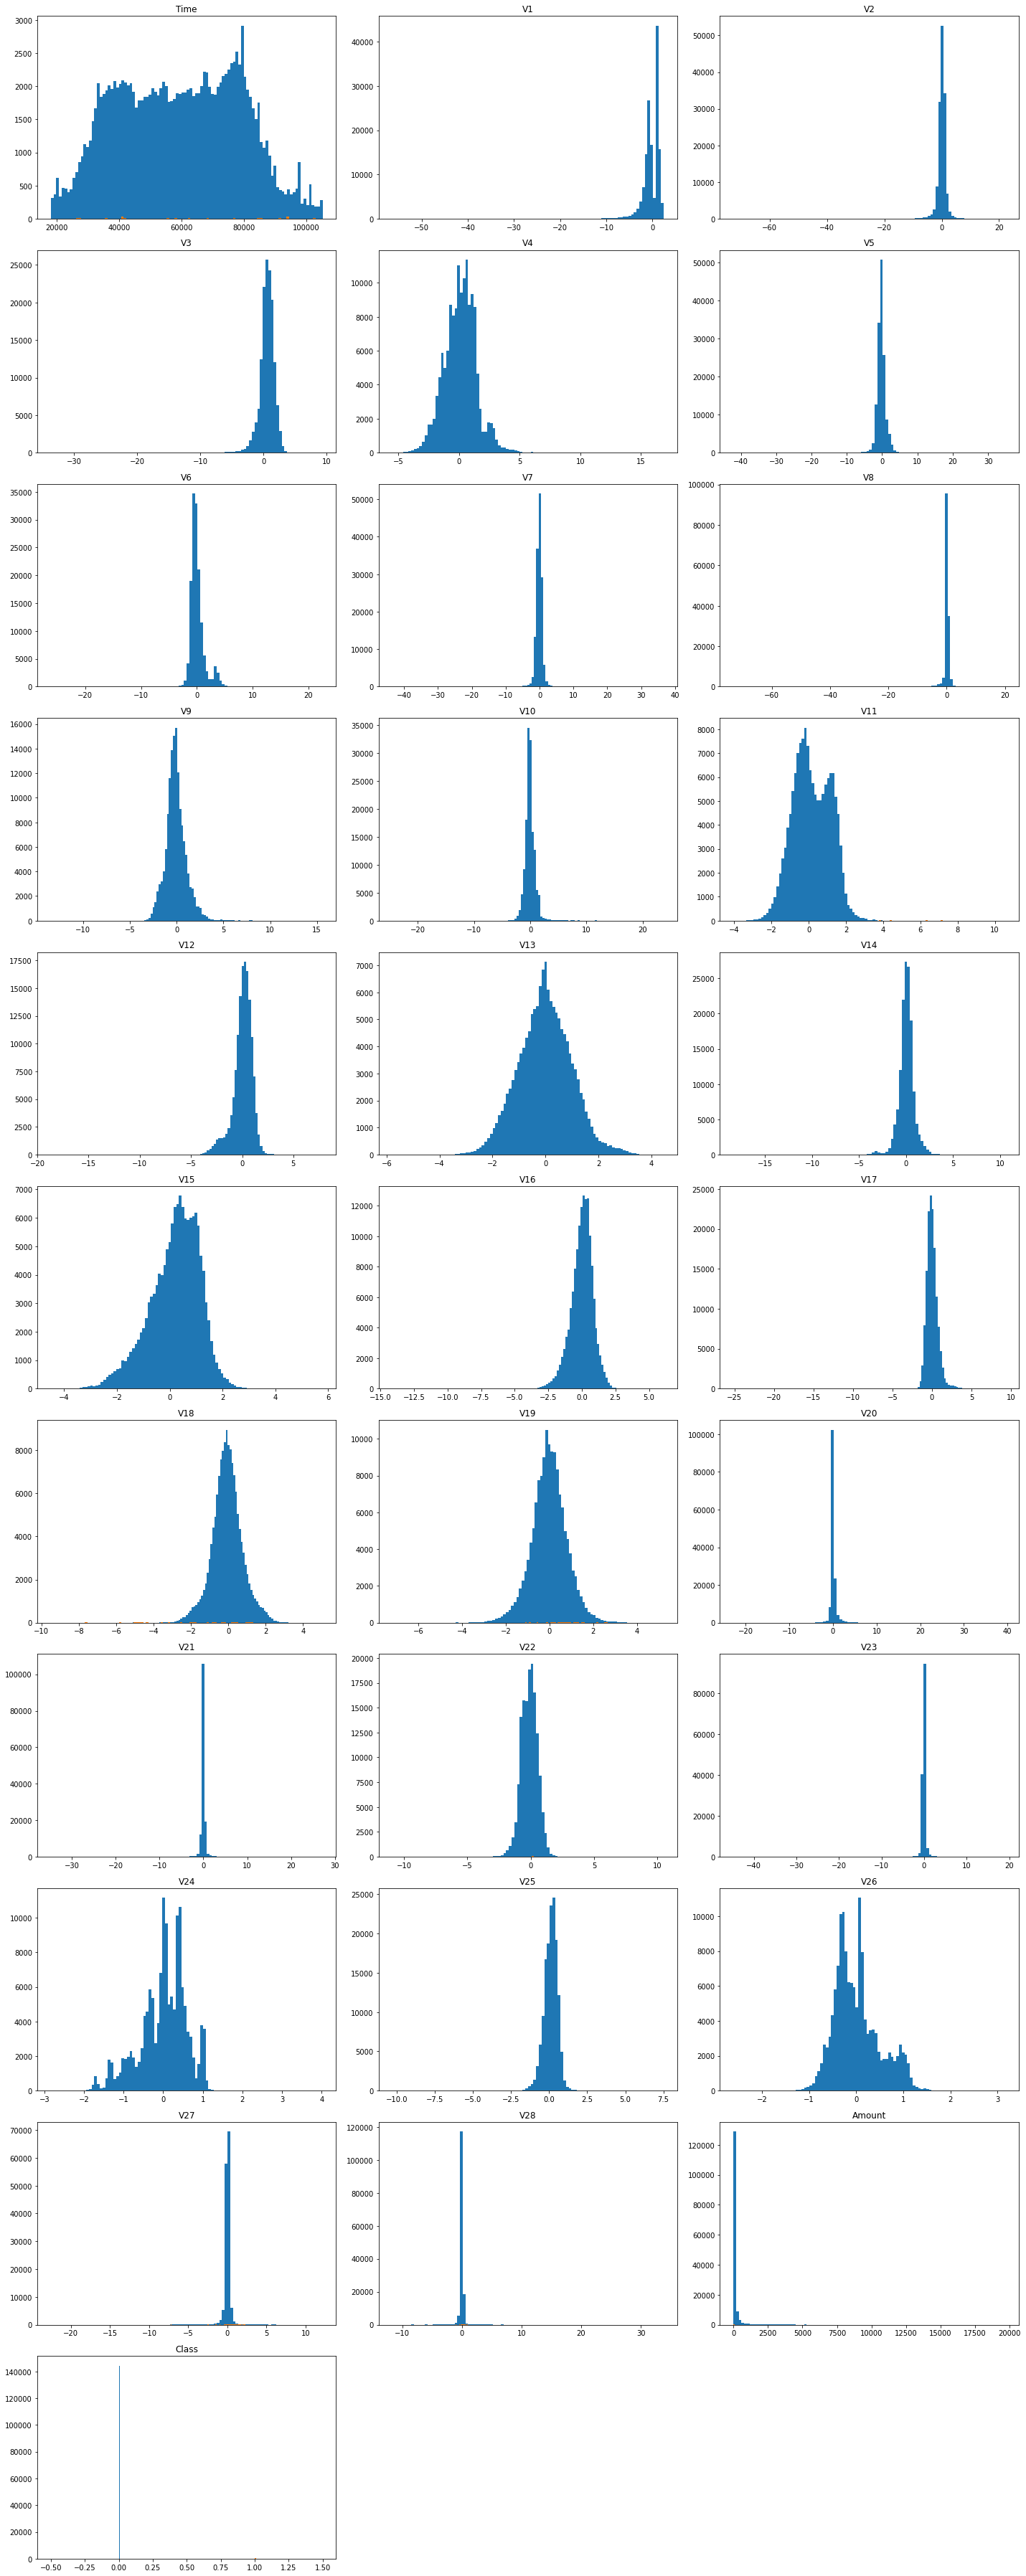

In [ ]:
plt.figure(figsize=(20,50))
i=1
for feature in normal.columns:
    plt.subplot(11,3,i)
    plt.hist(normal[feature], bins = 100)
    plt.hist(fraud[feature],bins = 100)
    plt.title(feature)
    i=i+1
plt.tight_layout()
plt.show()

It is very difficult to detect fraud transaction because in addition to severe class imbalance there is also severe class overlap.  Fraud transactions are mixed in with the normal ones.  It is important to go through the features one by one and make sure its appropriate to pass it to the models.  

We want enough features to be able to say something about the distribution but don't want too many as this will introduce noise.   

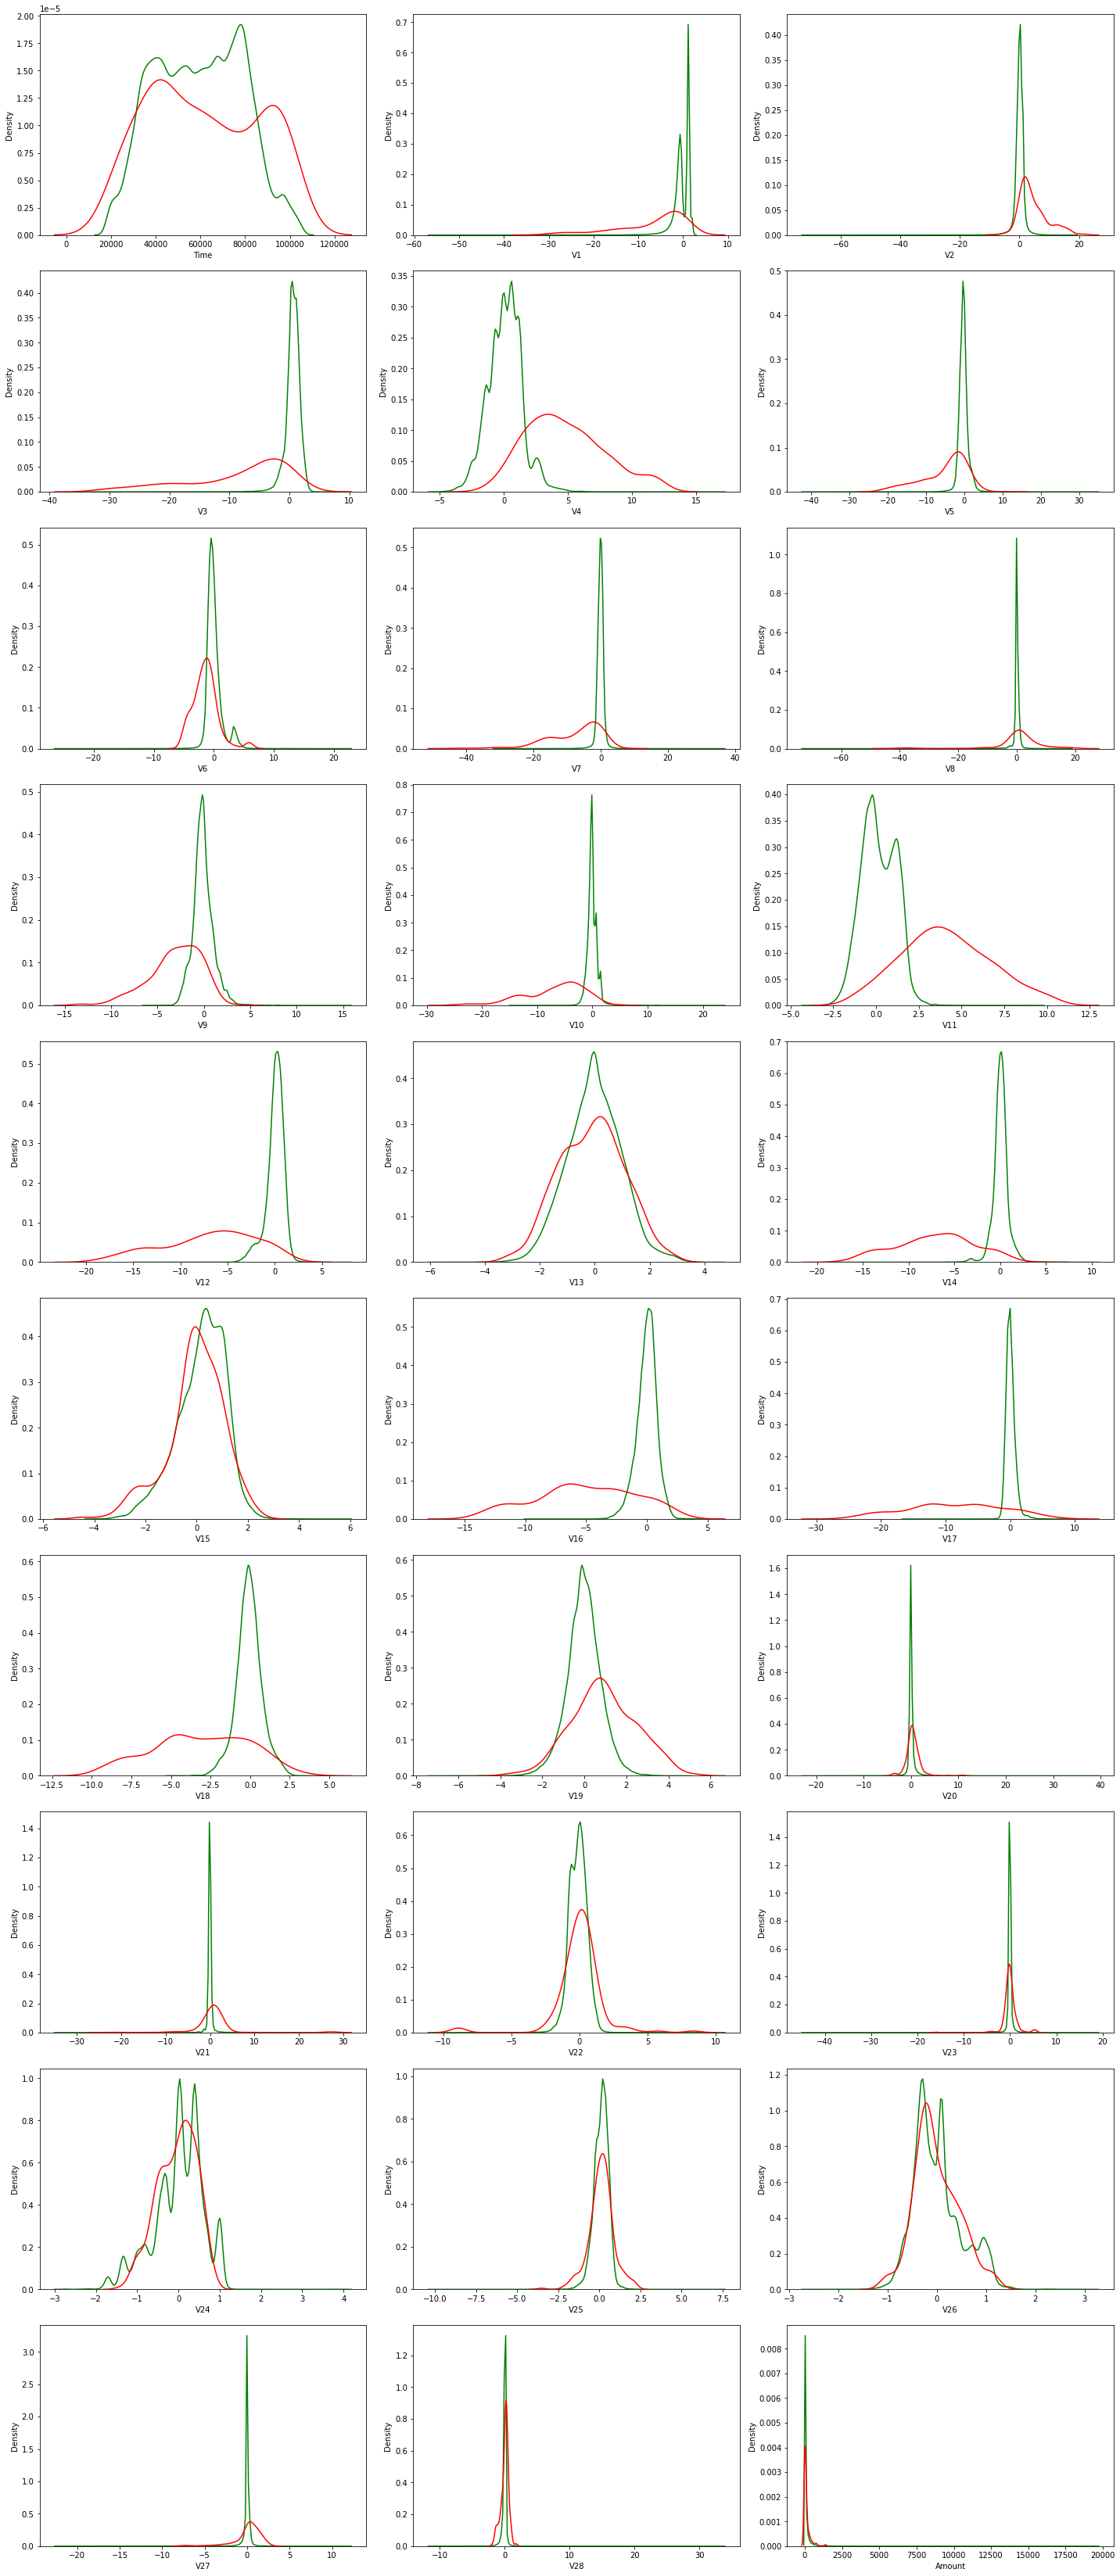

In [ ]:
features = Data.columns[:-1]

plt.figure(figsize=(20,50))
i=1
for feature in features:
    plt.subplot(11,3,i)
    sns.kdeplot(normal[feature] ,color='green' )
    sns.kdeplot(fraud[feature] ,color='red' )
    i=i+1
    plt.tight_layout()
plt.show()

Fraud is also very hard to detect because they are hiding in a lower dimensional subspace.  By looking at the kernel densities of the features we can select for features that can help to identify fraud transactions.   

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

#scale between (0,1)
Data_norm = MinMaxScaler().fit_transform(Data.iloc[:,:-1])
Data_norm = pd.DataFrame(Data_norm)
Data_norm['Class'] = Data['Class']
normal = Data_norm.loc[Data_norm['Class'] == 0, :]
fraud = Data_norm.loc[Data_norm['Class'] == 1, :]

In [ ]:
Data_norm.shape

(144635, 31)

Here we select for the features that make sense in this data.

We need to further reduce rows in the data but while retaining the meaningful information.  This is just to save time during training.  

In [ ]:
Data = Data_norm
X=Data.drop('Class', axis=1)
y = Data['Class']
print(X.shape)
print(y.shape)

In [ ]:

param_grid = {'n_estimators': list(range(100, 800, 5)), 
              'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False], 
              'n_jobs': [5, 10, 20, 30]}

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=10, 
                                                 return_train_score=True)


In [ ]:
classifiers = {
    "ISOLATION FOREST":IsolationForest(n_estimators=155, max_samples=len(X), 
                                       contamination=.00194,random_state=42, verbose=0),
    "LOCAL OUTLIER FACTOR":LocalOutlierFactor(n_neighbors=200, algorithm='auto', leaf_size=230, 
                            metric='euclidean', p=1, metric_params=None, contamination=.0021)
    
}

Choose parameters in a way that makes sense.   

In [1]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #;;;;;Fit the data and tag outliers
    if clf_name == "LOCAL OUTLIER FACTOR":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "ONE CLASS SVM":

        clf.fit(X)
        y_pred = clf.predict(X)
        
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)

    #;;;;;Translate prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1


    n_errors = (y_pred != y).sum()
    # ;;;;Run Classification Metrics
    # print("{} number of errors: {}".format(clf_name,n_errors))
    # print(pd.crosstab(y, y_pred)) 
    
    print('silhouette coefficient:',round(metrics.silhouette_score(Data, y_pred, metric='euclidean'), 3))
    print("Accuracy Score:",accuracy_score(y, y_pred))
    print("Precision_Score:",precision_score(y, y_pred))
    print("Recall Score:",recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
  
    # print("Classification Report :") 
    # print(classification_report(y,y_pred))

NameError: ignored

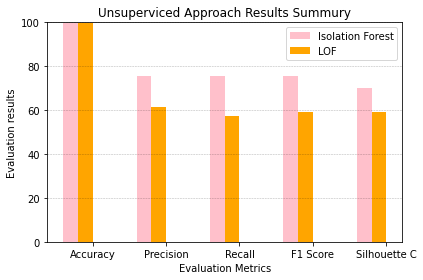

In [ ]:
data = np.array([[99.89, 99.83], [75.41, 61.40], [75.41, 57.38], [75.41, 59.32], [69.90, 59.32]])
data_std = np.array([[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]])    

length = len(data)
x_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Silhouette C']

# Set plot parameters
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='pink', label='Isolation Forest')
ax.bar(x + width, data[:,1], width, color='orange', label='LOF')

ax.set_ylabel('Evaluation results')
ax.set_ylim(0,100)
ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Evaluation Metrics')
ax.set_title('Unsuperviced Approach Results Summury')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()

In [ ]:

from sklearn.decomposition import PCA

Lets take a look at our sample in the 1st and 2nd PCA so we can get a general idea of the distribution. 

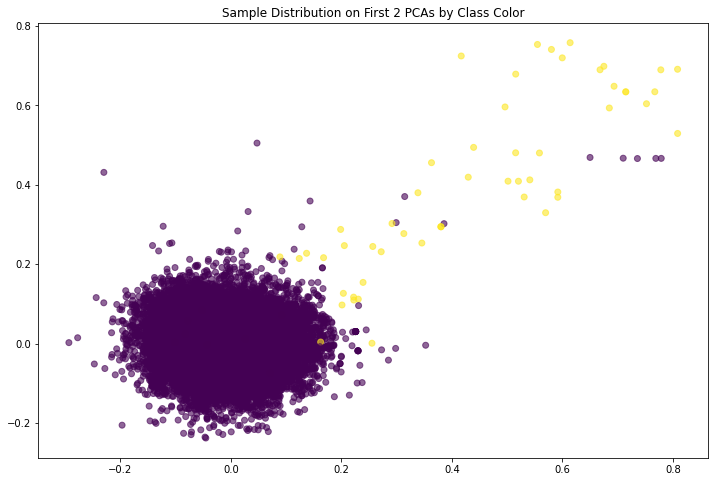

In [ ]:
pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns = ['pc1', 'pc2']

plt.figure(figsize=(12,8))
plt.title('Sample Distribution on First 2 PCAs by Class Color')
plt.scatter(x_pca['pc1'], x_pca['pc2'], alpha = .6, c=y)
plt.show()